In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import os

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 数据集类
class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.le = LabelEncoder()
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.annotations.iloc[index, -1]) + '.npy')
        image = np.load(img_name)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.annotations.iloc[index, 2]
        return image, label

# 模型定义
class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        # 使用预训练的MobileNetV3模型
        self.mobilenet = models.mobilenet_v3_large(pretrained=True)  # 或者mobilenet_v3_small，取决于你的需求
        self.dropout = nn.Dropout(0.2)  # 根据MobileNetV3的设计进行调整
        
        # MobileNetV3的分类器部分是一个自定义的Sequential模型，其最后一个层是线性层
        # 我们需要替换这个线性层以匹配我们的目标类别数
        num_ftrs = self.mobilenet.classifier[-1].in_features  # 获取线性层的输入特征数
        self.mobilenet.classifier[-1] = nn.Linear(num_ftrs, num_classes)  # 替换最后的线性层

    def forward(self, x):
        x = self.mobilenet(x)
        return x

# 训练和评估参数
num_epochs = 10
batch_size = 16
learning_rate = 0.0005

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = NPYDataset(csv_file='/kaggle/input/normalized-contrasted-d-n/train.csv', root_dir='/kaggle/input/normalized-contrasted-d-n/normalized_contrasted_train_images/normalized_contrasted_train_images')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = NPYDataset(csv_file='/kaggle/input/normalized-contrasted-d-n/validation.csv', root_dir='/kaggle/input/normalized-contrasted-d-n/normalized_contrasted_validation_images/normalized_contrasted_validation_images')
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = NPYDataset(csv_file='/kaggle/input/normalized-contrasted-d-n/test.csv', root_dir='/kaggle/input/normalized-contrasted-d-n/normalized_contrasted_test_images/normalized_contrasted_test_images')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))

# 创建一个权重数组
# 这里假设类别标签已经编码为0, 1
weights = torch.tensor([1.0, 1.0], dtype=torch.float32).to(device)

# 使用加权损失函数
criterion = nn.CrossEntropyLoss(weight=weights)

model = MobileNetV3(num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-1)  # 增加权重衰减

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型的代码...
# 请根据您的具体需求添加训练循环和验证/测试循环

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:02<00:00, 9.06MB/s]


In [2]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 确保模型在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 确保模型处于训练模式
model.train()

# 可能需要调整学习率
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # 示例学习率

for epoch in range(0, 15):  # 继续训练过程
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # 每个epoch结束后打印损失
    print(f'Epoch [{epoch+1}/{15}], Loss: {loss.item():.4f}')
    
    # 每个epoch结束后在训练集上评估模型
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        train_preds = []
        train_labels = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.view(-1).cpu().numpy())
            train_labels.extend(labels.view(-1).cpu().numpy())
        train_accuracy = 100 * np.sum(np.array(train_preds) == np.array(train_labels)) / len(train_labels)
        print(f'Train Accuracy: {train_accuracy:.2f} %')

    # 每个epoch结束后在验证集上评估模型
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.view(-1).cpu().numpy())
            val_labels.extend(labels.view(-1).cpu().numpy())
        val_accuracy = 100 * np.sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
        print(f'Validation Accuracy: {val_accuracy:.2f} %')
    
    # 每个epoch结束后在测试集上评估模型
    with torch.no_grad():
        test_preds = []
        test_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.view(-1).cpu().numpy())
            test_labels.extend(labels.view(-1).cpu().numpy())
    
        test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
        print(f'Test Accuracy: {test_accuracy:.2f} %')

        # 计算精确率、召回率和F1分数
        precision = precision_score(test_labels, test_preds, average='weighted')
        recall = recall_score(test_labels, test_preds, average='weighted')
        f1 = f1_score(test_labels, test_preds, average='weighted')
    
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
    
    model.train()  # 切换回训练模式

Epoch [1/15], Loss: 0.5711
Train Accuracy: 59.57 %
Validation Accuracy: 55.33 %
Test Accuracy: 58.00 %
Precision: 0.7397
Recall: 0.5800
F1 Score: 0.5005
Epoch [2/15], Loss: 0.2668
Train Accuracy: 69.86 %
Validation Accuracy: 63.33 %
Test Accuracy: 70.67 %
Precision: 0.7699
Recall: 0.7067
F1 Score: 0.6898
Epoch [3/15], Loss: 0.2967
Train Accuracy: 70.14 %
Validation Accuracy: 61.33 %
Test Accuracy: 65.33 %
Precision: 0.7616
Recall: 0.6533
F1 Score: 0.6158
Epoch [4/15], Loss: 0.0761
Train Accuracy: 79.86 %
Validation Accuracy: 66.00 %
Test Accuracy: 71.33 %
Precision: 0.7741
Recall: 0.7133
F1 Score: 0.6979
Epoch [5/15], Loss: 0.1898
Train Accuracy: 83.86 %
Validation Accuracy: 66.67 %
Test Accuracy: 72.00 %
Precision: 0.7702
Recall: 0.7200
F1 Score: 0.7076
Epoch [6/15], Loss: 0.2105
Train Accuracy: 84.14 %
Validation Accuracy: 65.33 %
Test Accuracy: 74.00 %
Precision: 0.7987
Recall: 0.7400
F1 Score: 0.7277
Epoch [7/15], Loss: 0.0804
Train Accuracy: 84.29 %
Validation Accuracy: 64.00 %
Te

In [3]:
import torch  
import numpy as np  
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  
  
# 假设model, test_loader, device等都已正确定义和初始化  
  
model.eval()  
with torch.no_grad():  
    all_preds = []  
    all_labels = []  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device).long()  
        outputs = model(images)  
        _, predicted = torch.max(outputs.data, 1)  
          
        # 收集所有预测和标签  
        all_preds.extend(predicted.view(-1).cpu().numpy())  
        all_labels.extend(labels.view(-1).cpu().numpy())  
  
    # 计算准确率  
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)  
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')  
      
    # 计算精确率、召回率和F1分数  
    precision = precision_score(all_labels, all_preds, average='weighted')  
    recall = recall_score(all_labels, all_preds, average='weighted')  
    f1 = f1_score(all_labels, all_preds, average='weighted')  
      
    print(f'Precision: {precision:.4f}')  
    print(f'Recall: {recall:.4f}')  
    print(f'F1 Score: {f1:.4f}')  
  
    # 计算混淆矩阵  
    cm = confusion_matrix(all_labels, all_preds)  
      
    # 计算每个类别的准确率  
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  
      
    # 打印每个类别的准确率  
    for i in range(len(class_accuracy)):  
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')  
  
# 打印所有预测结果（如果需要）  
# print('All Predictions:', all_preds)

Accuracy of the model on the test images: 76.00 %
Precision: 0.7807
Recall: 0.7600
F1 Score: 0.7561
Accuracy for class 0: 0.63
Accuracy for class 1: 0.89


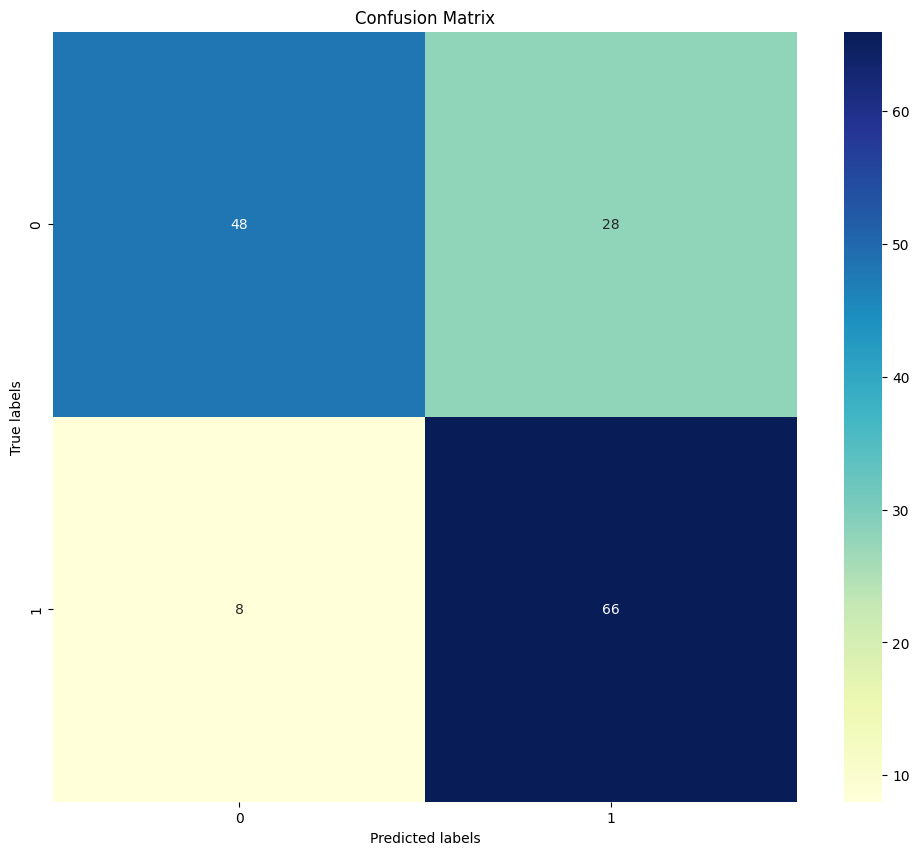

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 基于之前的预测结果计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(len(np.unique(all_labels))), yticklabels=range(len(np.unique(all_labels))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# 打印所有预测结果
print('All Predictions:', all_preds)

All Predictions: [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]


In [6]:
# Assuming `le` is your LabelEncoder instance that has been fitted to the labels
print("Label mapping:")
for i, label in enumerate(train_dataset.le.classes_):
    print(f"{label}: {i}")

Label mapping:
D: 0
N: 1


In [7]:
# 保存模型权重
model_path = '/kaggle/working/trained_model.pth'  # 指定模型保存路径
torch.save(model.state_dict(), model_path)  # 保存模型权重